# Let's try our recognizer on SVHN dataset

## Figure size which we will use for resizing all images  
Let's find average size and ratio of images. maybe we will resize to it

In [3]:
# Load images and check their average size
from PIL import Image
import os

In [6]:
dataset_folder = 'SVHN_data'
train_folder = os.path.join(dataset_folder, 'train')

In [7]:
# Let's look for average ratio in train dataset
av_x, av_y = 99,47 # These values were obtained from random image
train_names = os.listdir(train_folder)
i = 1
image_extension = 'png'
for name in train_names:
    is_image = name[-3:] == image_extension
    if is_image:
        image_filepath = os.path.join(dataset_folder, 'train', name)
        image = Image.open(image_filepath)
        x, y = image.size
        av_x = (av_x * i + x) / (i+1)
        av_y = (av_y * i + y) / (i+1)
        i += 1
        image.close()
        
ratio = av_x / av_y
print('Average ration is:', ratio)
print('This means if y is 28, then x is', av_y * ratio)

Average ration is: 2.2422181523246274
This means if y is 28, then x is 128.28546194838566


In [8]:
print('Average size in train dataset is ({}, {})'.format(av_x, av_y))

Average size in train dataset is (128.28546194838566, 57.213639901802274)


let's look at image with this ratio and play with size

[156, 70]


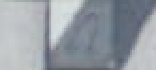

In [9]:
img = Image.open(image_filepath)
new_size = [int(ratio*70), 70]
print(new_size)
img.resize(new_size)

Maybe later try to work with them. No I will choose this small size (it's a little bit bigger than in synthesized dataset)

In [24]:
ratio = 2.24223107819886
image_height = 70
image_width = int(ratio * image_height)
print('[h:{}, w:{}]'.format(image_height, image_width))

[h:70, w:156]


## Load and prepare data

> I wonder. Will it be hard for dictionary to contain too much info?  
  Will be better here to use variables instead of that. Because it doesn't looks simple anyway.  
  **Try to check it later**

In [1]:
ratio = 2.24223107819886
image_height = 70
image_width = int(ratio * image_height)

Let's transform our datasets into objects with nice API

In [2]:
import os
import pickle
import numpy as np
from PIL import Image

def normalize(arr):
    arr=arr.astype('float32', copy=False)
    if arr.max() > 1.0:
        arr/=255.0
    return arr

class Dataset:
    num_classes = 11 # 10 [0-9] digits and 11 for empty digit label
    no_digit_label = 10 # 11-th digit (which is 10) doesn't exist
    digits_limit = 5
    
    """Represents part of SVHN dataset. Contain images of required size and labels"""
    def __init__(self, name, size, images, labels, image_size):
        self.name = name
        self.size = size
        self.images = images
        self.image_size = image_size
        self.labels = labels 
        
        self.idx = 0
    
    @classmethod
    def from_directory(cls, name, folder_path, labels_file_path, image_size):
        with open(labels_file_path, 'rb') as labels_file:
            dataset_info = pickle.load(labels_file)
        
        # this hack for one image with 6 digits
        if name == 'train':
            del dataset_info['29930.png']
        
        size = len(dataset_info)
        image_size = image_size
        width, height = image_size
        images = np.empty([size, height, width, 3], dtype='uint8')
        labels = np.full([size, Dataset.digits_limit], Dataset.no_digit_label)
        
        i = 0
        for image_file_name, boxes in dataset_info.items():
            # Add next image
            image_path = os.path.join(folder_path, image_file_name)
            with Image.open(image_path) as image:
                resized_image = image.resize(image_size)
                images[i] = normalize(np.array(resized_image))
            
            # Add next label
            for j, box in enumerate(boxes):
                labels[i][j] = box['label']
            
            i+=1
            
        ds = Dataset(name, size, images, labels, image_size)
        return ds
    
    @classmethod
    def from_pickle(cls, filename):
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        return dataset
    
    def to_pickle(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def next_batch(self, size):
        """
        Args:
            size(int): size of batch
            
        Returns:
            images(np.ndarray): images. shape [size, height, width, 3]
            labels(np.ndarray): labels for classifiers. shape [digits_limit, size]
            digits_counts(np.array): labels for counts_classifier. shape [size]
        """
        
        width, height = self.image_size
        images = np.empty([size, height, width, 3])
        labels = np.empty([size, self.digits_limit])
        digits_counts = np.empty([size])
        
        for i in range(size):
            images[i] = self.images[self.idx]
            labels[i] = self.labels[self.idx]
            
            digits_count = 0
            for digit in labels[i]:
                if digit != self.no_digit_label:
                    digits_count += 1
            digits_counts[i] = digits_count
            
            self.idx = (self.idx + 1) % self.size
        
        # Reshape labels for classifiers
        labels = labels.T
        digits_counts = digits_counts.reshape([-1, 1])
        return images, labels, digits_counts

----

### Write dataset to files

In [2]:
dataset_folder = 'SVHN_data'
dataset_names = ['train', 'test']

In [6]:
ratio = 2.24223107819886
image_height = 70
image_size = (int(ratio * image_height), image_height) # [156, 70]. Look previous section for details

for name in dataset_names:
    folder_path = os.path.join(dataset_folder, name)
    labels_file_path = os.path.join(folder_path, name+'.pickle')
    dataset = Dataset.from_directory(name, folder_path, labels_file_path, image_size)
    
    dataset_file = os.path.join(dataset_folder, name+'.pickle')
    dataset.to_pickle(dataset_file)

Move it to SVHM dataset cracking notebook.    
Create batch generator oooooor implement needed methods in Dataset class (need slightly change format of labels (one hot encoding)  
Start learning model with this data.     

### Read dataset

In [3]:
dataset_folder = 'SVHN_data'
dataset_names = ['train', 'test']

In [4]:
datasets = []
for name in dataset_names:
    dataset_file = os.path.join(dataset_folder, name+'.pickle')
    datasets.append(Dataset.from_pickle(dataset_file))

In [5]:
# And don't forget about validation
def split_dataset(dataset, ratio):
    """
    Split dataset in two by ratio
    
    Args:
        dataset(Dataset): dataset to split in two
        ratio(float in range [0, 1]): which part of source dataset will become first in split
        
    Returns:
        datasets (Dataset, Dataset)
    """
    
    size = dataset.size
    first_size = int(ratio * size)
    second_size = size - first_size
    
    dataset_1 = Dataset("", first_size, dataset.images[:first_size], 
                        dataset.labels[:first_size], dataset.image_size)
    
    dataset_2 = Dataset("", second_size, dataset.images[first_size:], 
                        dataset.labels[first_size:], dataset.image_size)
    
    return dataset_1, dataset_2

In [7]:
train_dataset, validation_dataset = split_dataset(datasets[0], 0.7)
test_dataset = datasets[1]

# Prepare and train our model from 'MNIST numbers recognizer.ipynb'

In [8]:
import tensorflow as tf

In [9]:
# Operations wrappers
def weights_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.2)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [10]:
from abc import ABC, abstractmethod

class LinearModel(ABC):
    '''As we have a graph, we dont need methods like
        def logits(self, x):
        def loss(self, x, y):
        def predictions(self, x):
        
        because we don't really passing data to these tensors
        we just passing tensors, where this data will be again and again (they still the same)
        
        instead of that we can connect tensors in right way once
        and save resulting tensors in fields
        After that we can execute them in a session easier
        '''
    
    @abstractmethod
    def __init__(self, num_features, num_classes, x, y):  
        self.num_features = num_features
        self.num_classes = num_classes
        
        self.w = weights_variable([num_features, num_classes])
        self.b = bias_variable([num_classes])
        
        self.logits = tf.matmul(x, self.w) + self.b
        self.optimizer = tf.train.AdagradOptimizer(learning_rate = 0.007)
         
class LinearClassifier(LinearModel):
    def __init__(self,  num_features, num_classes, x, y):
        LinearModel.__init__(self, num_features, num_classes, x, y)
        
        # Loss
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.logits, labels=y)
        self.loss = tf.reduce_mean(cross_entropy)
        
        # Probabilities and predictions
        self.probabilities = tf.nn.softmax(self.logits)
        self.predictions = tf.argmax(self.probabilities, axis=1)
        
        # Accuracy
        labels = y
        self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predictions, labels), tf.float32))
        
        # Training
        self.train_step = self.optimizer.minimize(self.loss)
    
class LinearRegression(LinearModel):
    def __init__(self,  num_features, num_classes, x, y):
        LinearModel.__init__(self, num_features, 1, x, y)
        
        # Loss
        mse = tf.reduce_mean(tf.squared_difference(self.logits, y))
        self.loss = mse
        
        # Predictions
        self.predictions = self.logits # to int and the calculate accuracy!
        
        # Training
        self.train_step = self.optimizer.minimize(self.loss)

In [11]:
digits_per_image = 5
num_classes = 11
num_classifiers = digits_per_image

In [12]:
graph = tf.Graph()

with graph.as_default():
    # conv > pool > conv > pool > fc1 > dropout > (5 or more linear classifiers and 1 for digits count)
    x = tf.placeholder(tf.float32, shape=[None, image_height, image_width, 3])
    ys = tf.placeholder(tf.int64, shape=[digits_per_image, None])
    y_cnt = tf.placeholder(tf.float32, shape=[None, 1])
    
    W_conv1 = weights_variable([5, 5, 3, 32])
    b_conv1 = bias_variable(32)
    
    h_conv1 = tf.nn.relu(conv2d(x, W_conv1) + b_conv1)
    h_pool1 = max_pool2x2(h_conv1)
    
    W_conv2 = weights_variable([5, 5, 32, 64])
    b_conv2 = bias_variable(64)
    
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool2x2(h_conv2)
    
    # A little bit hacky.
    # I should learn to calc conv shapes in mind on fly
    flat_size = int(h_pool2.shape[1] * h_pool2.shape[2] * h_pool2.shape[3])
    print(h_pool2.shape, flat_size)
    
    fc1_size = 1024
    W_fc1 = weights_variable([flat_size, fc1_size])
    b_fc1 = bias_variable([fc1_size])
    
    h_pool2_flat = tf.reshape(h_pool2, [-1, flat_size])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    keep_prob = tf.placeholder(tf.float32)
    dropout = tf.nn.dropout(h_fc1, keep_prob)
    
    image_embeds = dropout
    
    # Digits classifiers
    # ================================================================
    digits_classifiers = []
    for i in range(num_classifiers):
        i_th_digit_classifier = LinearClassifier(fc1_size, num_classes, image_embeds, ys[i])
        digits_classifiers.append(i_th_digit_classifier)
    
    # Digits count classifier
    count_classifier = LinearRegression(fc1_size, num_classes, image_embeds, y_cnt)
    top_classifiers = digits_classifiers + [count_classifier]
    
    # Summary loss
    summary_loss = 0
    for c in top_classifiers: # or in digits_classifiers only?
        summary_loss += c.loss
    average_loss = summary_loss / (num_classifiers + 1)
    
    summary_train_step = tf.train.AdamOptimizer(learning_rate=0.007).minimize(average_loss)

(?, 18, 39, 64) 44928


In [13]:
num_steps = 2000
batch_size = 64
training_approach = "use summary loss"
validation_size = 300 # todo choose it right
test_size = 300
print_size = 10

with tf.Session(graph=graph) as session:
    session.run(tf.global_variables_initializer())
    
    # Arrays to train all in one session
    train_steps = [c.train_step for c in top_classifiers]
    losses = [c.loss for c in digits_classifiers]
    accuracies = [c.accuracy for c in digits_classifiers]
    tensors_to_run = None
    
    for i in range(num_steps):
        images, labels, digits_count = train_dataset.next_batch(batch_size)
        feed_dict = {
            x: images,
            ys: labels,
            y_cnt: digits_count,
            keep_prob: 0.5
        }
  
        # Training
        if training_approach == "use summary loss":
            session.run(summary_train_step, feed_dict=feed_dict)
        elif training_approach == "train separately":
            session.run(train_steps, feed_dict=feed_dict)

        if i % 10 == 0: 
            print(f'step {i}')

        # Validation
        if i % 250 == 0:
            images, labels, digits_count = validation_dataset.next_batch(validation_size)
            feed_dict = {
                x: images,
                ys: labels,
                y_cnt: digits_count,
                keep_prob: 1.0
            }

            if tensors_to_run is None:
                tensors_to_run = [losses, accuracies, count_classifier.loss, average_loss]

            cls_l, cls_a, cnt_cls_l, a_l = session.run(tensors_to_run, feed_dict=feed_dict)
            print(f"Average loss {a_l}")
            for j in range(num_classifiers):
                print(f"{j}th digit classifier: [accuracy: {cls_a[j]}, loss: {cls_l[j]}]")
            print(f"Count classifier loss: {cnt_cls_l}")
          
    # we can also continue session later
    # https://stackoverflow.com/questions/41037650/how-to-restore-session-in-tensorflow
    # https://www.tensorflow.org/versions/r0.12/api_docs/python/client/session_management   
    # test
    print(f'Test for {test_size} images')
    images, labels, digits_count = test_dataset.next_batch(test_size)
    feed_dict = {
        x: images,
        ys: labels,
        y_cnt: digits_count,
        keep_prob: 1.0
    }
    
    # Accuracy
    if tensors_to_run is None:
        tensors_to_run = [losses, accuracies, count_classifier.loss, average_loss]

    cls_l, cls_a, cnt_cls_l, a_l = session.run(tensors_to_run, feed_dict=feed_dict)
    print(f"Average loss {a_l}")
    for j in range(num_classifiers):
        print(f"{j}th digit classifier: [accuracy: {cls_a[j]}, loss: {cls_l[j]}]")
    print(f"Count classifier loss: {cnt_cls_l}")

    # Actual predictions
    print("Some samples")
    predictions = [c.predictions for c in top_classifiers]
    
    c_ps = session.run(predictions, feed_dict=feed_dict)
    predicted_digits = c_ps[:digits_per_image]
    for i in range(print_size):
        plt.imshow(images[i].squeeze())
        plt.show()
        
        number = ''
        for j in range(num_classifiers):
            digit = predicted_digits[j][i]
            if digit != num_classes-1: # 'no digit' encoded as max digit
                number += str(digit)
                
        predicted_length = c_ps[-1]
        print('Predicted {} length of {}'.format(number, predicted_length[i]))
        
    # Save trained model
    saver = tf.train.Saver()
    saver.save(session, "/tmp/model.ckpt")
    
    # We can restore them later. Just read 
    # https://www.tensorflow.org/programmers_guide/saved_model

step 0
Average loss 28763.802734375
0th digit classifier: [accuracy: 0.006666666828095913, loss: 35.8723258972168]
1th digit classifier: [accuracy: 0.07999999821186066, loss: 36.61647033691406]
2th digit classifier: [accuracy: 0.7266666889190674, loss: 18.594942092895508]
3th digit classifier: [accuracy: 0.006666666828095913, loss: 28.696243286132812]
4th digit classifier: [accuracy: 0.07000000029802322, loss: 13.799060821533203]
Count classifier loss: 172449.234375
step 10
step 20


KeyboardInterrupt: 